In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


def load_and_preprocess_data(file_path):
    """
    Load and preprocess the CKD dataset for federated learning.

    Args:
        file_path (str): Path to the dataset CSV file.

    Returns:
        dict: A dictionary containing preprocessed train and test sets for each hospital.
    """
    # Load dataset
    data = pd.read_csv(file_path)

    # Drop duplicates and reset index
    data = data.drop_duplicates().reset_index(drop=True)

    # Handle missing values
    data.fillna({
        'Sex': 'Unknown',
        'HistorySmoking': 'Unknown',
        'CholesterolBaseline': data['CholesterolBaseline'].mean(),
        'CreatinineBaseline': data['CreatinineBaseline'].mean(),
        'eGFRBaseline': data['eGFRBaseline'].mean(),
        'BMIBaseline': data['BMIBaseline'].mean()
    }, inplace=True)

    # Encode categorical features
    label_encoders = {}
    for col in ['Sex', 'HistorySmoking']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    # Normalize numerical features
    numerical_cols = [
        'AgeBaseline', 'CholesterolBaseline', 'CreatinineBaseline',
        'eGFRBaseline', 'sBPBaseline', 'dBPBaseline', 'BMIBaseline'
    ]
    scaler = MinMaxScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Split data into target and features
    X = data.drop(columns=['EventCKD35', 'TimeToEventMonths', 'TIME_YEAR'])
    y = data['EventCKD35']

    # Simulate federated data by splitting into hospital subsets
    hospital_data = {}
    num_hospitals = 3  # Number of hospitals (nodes)
    X_splits = np.array_split(X, num_hospitals)
    y_splits = np.array_split(y, num_hospitals)

    for i in range(num_hospitals):
        X_train, X_test, y_train, y_test = train_test_split(
            X_splits[i], y_splits[i], test_size=0.2, random_state=42
        )
        hospital_data[f'hospital_{i+1}'] = {
            'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test
        }

    return hospital_data, scaler, label_encoders

# Example usage in Colab
if __name__ == "__main__":
    # Update with your dataset's path in Google Drive
    file_path = 'ChronicKidneyDisease_EHRs_from_AbuDhabi.csv'
    hospital_data, scaler, label_encoders = load_and_preprocess_data(file_path)
    print("Preprocessing complete. Data split for federated learning.")


Preprocessing complete. Data split for federated learning.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Concatenate, Dropout, BatchNormalization
)

def build_mlp_lstm_model(input_dim):
    input_layer = Input(shape=(input_dim,), name="Input_Layer")

    # MLP Branch
    mlp = Dense(256, activation='relu')(input_layer)
    mlp = BatchNormalization()(mlp)
    mlp = Dropout(0.4)(mlp)
    mlp = Dense(128, activation='relu')(mlp)
    mlp = BatchNormalization()(mlp)
    mlp = Dropout(0.4)(mlp)

    # LSTM Branch (Reshaping for Sequential Processing)
    lstm_input = tf.keras.layers.Reshape((input_dim, 1))(input_layer)
    lstm = LSTM(128, return_sequences=False, activation='tanh')(lstm_input)
    lstm = Dropout(0.4)(lstm)

    # Concatenate MLP and LSTM Outputs
    combined = Concatenate(name="Concatenate_Layer")([mlp, lstm])

    # Dense Layers after Concatenation
    dense = Dense(64, activation='relu')(combined)
    dense = Dropout(0.4)(dense)
    dense = Dense(32, activation='relu')(dense)

    # Output Layer
    output_layer = Dense(1, activation='sigmoid', name="Output_Layer")(dense)

    # Build and Compile the Model
    model = Model(inputs=input_layer, outputs=output_layer, name="Refined_MLP_LSTM_Model")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# Example Usage
if __name__ == "__main__":
    # Example input dimension (update based on your preprocessed data)
    input_dim = 21  # Replace with the actual number of features
    model = build_mlp_lstm_model(input_dim)
    model.summary()


Model: "Refined_MLP_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 21)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │          5,632 │ Input_Layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 21, 1)          │              0 │ Input_Layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ dense_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │         66,560 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Concatenate_Layer         │ (None, 256)            │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │         16,448 │ Concatenate_Layer[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 32)             │          2,080 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 1)              │             33 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 125,185 (489.00 KB)

 Trainable params: 124,417 (486.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("/content/ChronicKidneyDisease_EHRs_from_AbuDhabi.csv")  # Update with the correct file path

# Handle missing values (if any)
df = df.dropna()  # Or fill missing values if needed

# Features (X) and target variable (y)
X = df.drop(columns=['EventCKD35'])  # Replace 'EventCKD35' with your target column
y = df['EventCKD35']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping the input for LSTM (3D input required: [samples, timesteps, features])
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss/accuracy curves.

    Args:
    - history: The history object returned by the model.fit() method.
    """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    # plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots the confusion matrix.

    Args:
    - y_true: True labels.
    - y_pred: Predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CKD', 'CKD'], yticklabels=['No CKD', 'CKD'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    """
    Plots the ROC curve.

    Args:
    - y_true: True labels.
    - y_pred_proba: Predicted probabilities.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_precision_recall_curve(y_true, y_pred_proba):
    """
    Plots the Precision-Recall curve.

    Args:
    - y_true: True labels.
    - y_pred_proba: Predicted probabilities.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    average_precision = average_precision_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights: ", class_weight_dict)

Class Weights:  {0: 0.5632183908045977, 1: 4.454545454545454}


In [ ]:
# Train the model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=6,  # Adjust epochs as needed
    batch_size=2,
    verbose=1
)



# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Early stopping to monitor validation loss
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Save the best model during training
# model_checkpoint = ModelCheckpoint('best_mlp_lstm_model.keras', save_best_only=True)

# # Train the model with callbacks
# history = model.fit(
#     X_train_lstm, y_train,
#     epochs=50,
#     batch_size=32,
#     validation_data=(X_test_lstm, y_test),
#     class_weight=class_weight_dict,
#     callbacks=[early_stopping, model_checkpoint]
# )

Epoch 1/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6028 - loss: 0.6642 - val_accuracy: 0.8788 - val_loss: 0.3167
Epoch 2/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8587 - loss: 0.3842 - val_accuracy: 0.8788 - val_loss: 0.2780
Epoch 3/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8791 - loss: 0.3011 - val_accuracy: 0.8788 - val_loss: 0.2869
Epoch 4/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9197 - loss: 0.2501 - val_accuracy: 0.9192 - val_loss: 0.2438
Epoch 5/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8788 - loss: 0.2941 - val_accuracy: 0.9091 - val_loss: 0.2767
Epoch 6/6
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8759 - loss: 0.2720 - val_accuracy: 0.9091 - val_loss: 0.2606


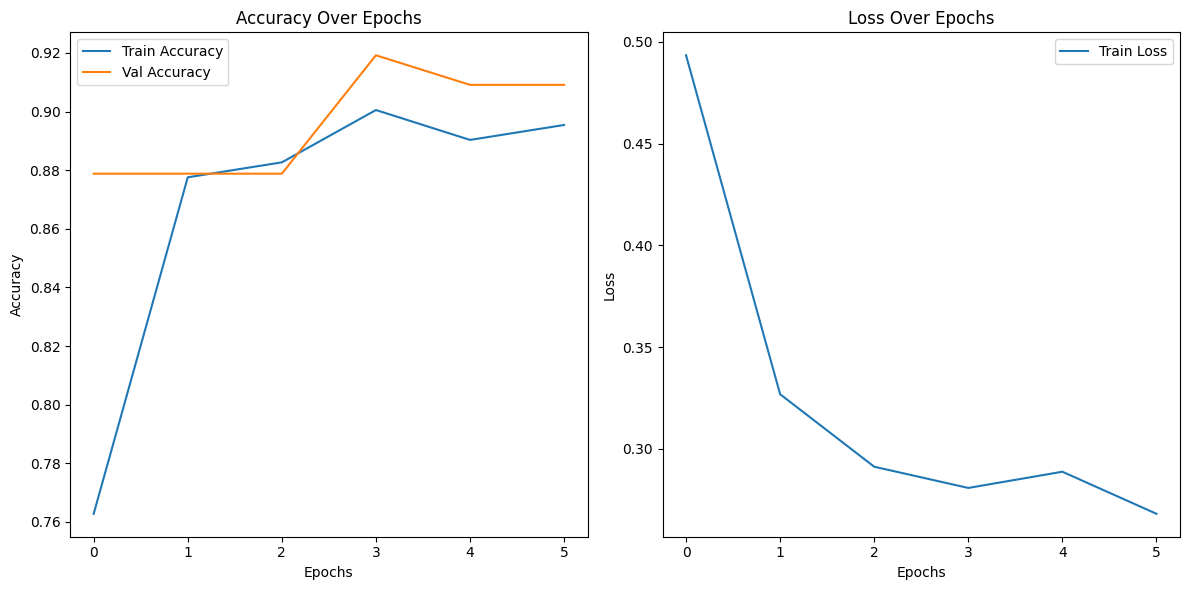

In [ ]:
plot_training_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


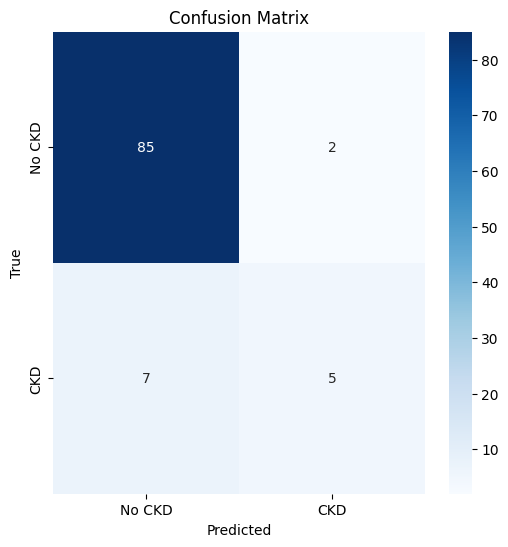

In [ ]:
y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)  # Predict labels

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


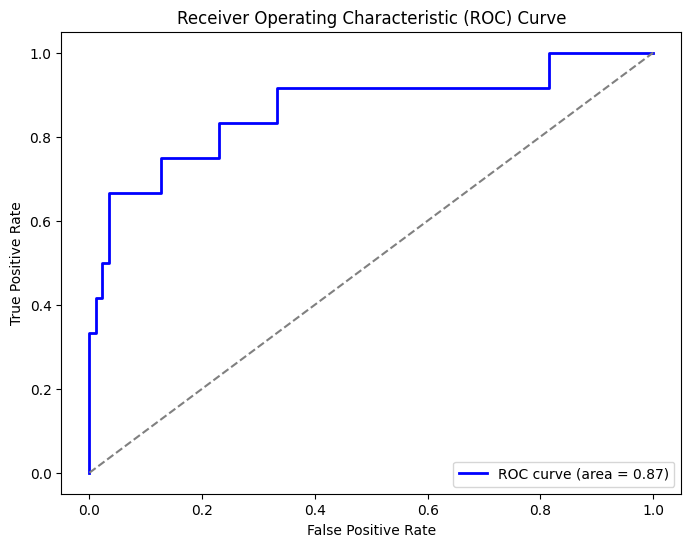

In [ ]:
y_pred_proba = model.predict(X_test_lstm)  # Get predicted probabilities
plot_roc_curve(y_test, y_pred_proba)

In [ ]:
# Predict using the refined model
y_pred = (model.predict(X_test_lstm) > 0.5)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Accuracy: 0.9091
Precision: 0.7143
Recall: 0.4167
F1 Score: 0.5263


In [ ]:
# Initialize the global model
input_dim = X_train_lstm.shape[1]  # Get the input dimension
global_model = build_mlp_lstm_model(input_dim)

In [ ]:
import copy
import numpy as np

def federated_learning(global_model, hospital_data, num_rounds=10):
    """
    Perform federated learning by training the model across multiple hospitals.

    Args:
        global_model (Model): The global model that is shared and updated.
        hospital_data (dict): Dictionary of training and test data for each hospital.
        num_rounds (int): Number of federated learning rounds.

    Returns:
        Model: The updated global model.
    """
    for round_num in range(num_rounds):
        print(f"Round {round_num + 1}/{num_rounds}")

        # Store the model weights at the start of each round
        global_weights = global_model.get_weights()

        # List to store updated models from each hospital
        hospital_weights = []

        # Simulate training on each hospital's data
        for hospital_name, data in hospital_data.items():
            print(f"Training at {hospital_name}...")
            # Load data
            X_train, y_train = data['X_train'], data['y_train']
            # Fit the model locally
            model_copy = copy.deepcopy(global_model)  # Create a copy of the global model for local training
            model_copy.fit(X_train, y_train, epochs=6, batch_size=2, verbose=1)  # Train on local data
            hospital_weights.append(model_copy.get_weights())  # Store the model's weights

        # Average the weights from all hospitals
        averaged_weights = average_weights(hospital_weights)

        # Update the global model with the averaged weights
        global_model.set_weights(averaged_weights)

    return global_model

def average_weights(weights_list):
    """
    Average the weights from different hospitals.

    Args:
        weights_list (list): List of model weights from different hospitals.

    Returns:
        Averaged weights.
    """
    # Calculate the average of each layer's weights across all hospitals
    avg_weights = []
    for weights in zip(*weights_list):
        avg_weights.append(np.mean(weights, axis=0))  # Average weights layer by layer

    return avg_weights


In [ ]:
X_train_lstm.shape

(392, 21, 1)

In [ ]:
y.shape

(491,)

In [ ]:
y = y[:X_train_lstm.shape[0]]

In [ ]:
hospital_data = {}
hospital_names = ['Hospital_1', 'Hospital_2', 'Hospital_3']  # Replace with your actual hospital names

# Example: Split the dataset into different hospitals
for hospital in hospital_names:
    # Assuming X_train_lstm and y_train are already available
    X_train, X_test, y_train, y_test = train_test_split(X_train_lstm, y, test_size=0.2, random_state=42)
    hospital_data[hospital] = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}


In [ ]:
# Initialize the global model
global_model = build_mlp_lstm_model(input_dim)

# Run federated learning for 10 rounds (you can adjust the number of rounds)
global_model = federated_learning(global_model, hospital_data, num_rounds=10)

Round 1/10
Training at Hospital_1...
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3589 - loss: 1.1040
Epoch 2/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8780 - loss: 0.4165
Epoch 3/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9035 - loss: 0.3495
Epoch 4/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8812 - loss: 0.3910
Epoch 5/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8987 - loss: 0.3579
Epoch 6/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8836 - loss: 0.4130
Training at Hospital_2...
Epoch 1/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3977 - loss: 1.1224
Epoch 2/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8867 - loss: 0.4011
Epoch 3/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8687 - loss: 0.4112
Epoch 4/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9012 - loss: 0.3796
Epoch 5/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8629 - loss: 0.4277
Epoch 6/6
157/157 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Example of aggregating test data from different hospitals
X_test_aggregated = np.concatenate([hospital_data[hospital]['X_test'] for hospital in hospital_names], axis=0)
y_test_aggregated = np.concatenate([hospital_data[hospital]['y_test'] for hospital in hospital_names], axis=0)

# Now you can use the aggregated test data for evaluation
y_pred = (global_model.predict(X_test_aggregated) > 0.5).astype(int)

# Evaluate metrics on the aggregated test set
accuracy = accuracy_score(y_test_aggregated, y_pred)
precision = precision_score(y_test_aggregated, y_pred)
recall = recall_score(y_test_aggregated, y_pred)
f1 = f1_score(y_test_aggregated, y_pred)

print(f"Final Global Model Evaluation on Aggregated Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Final Global Model Evaluation on Aggregated Test Set:
Accuracy: 0.8987
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


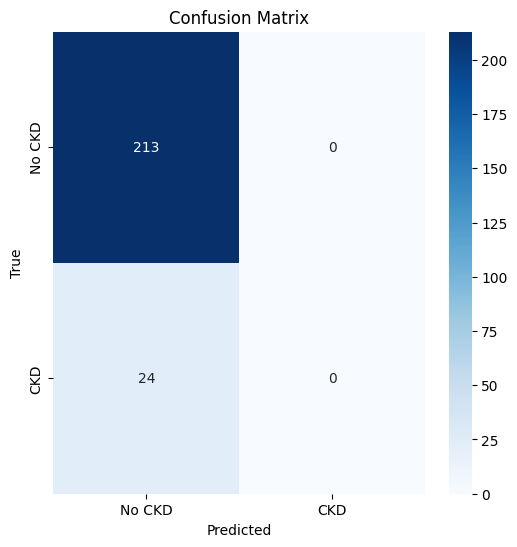

In [ ]:
 from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_aggregated, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CKD', 'CKD'], yticklabels=['No CKD', 'CKD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test_aggregated, global_model.predict(X_test_aggregated))
print(f"AUC Score: {auc_score:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
AUC Score: 0.3785


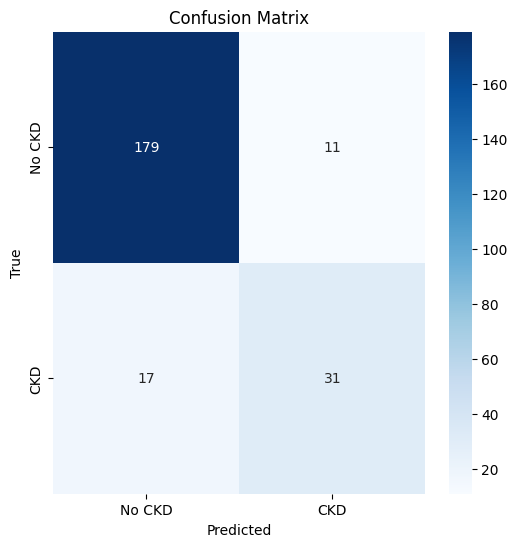

Confusion Matrix:
[[179  11]
 [ 17  31]]
Accuracy: 0.89
Precision: 0.74
Recall: 0.65
F1 Score: 0.69


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the true values of Precision, Recall, F1 score
precision = 0.74
recall = 0.65
f1_score = 0.69
accuracy = 0.89

# Total samples (for simplicity, assume a small sample size)
total_samples = 237

# Compute TP, FP, FN, TN using the formulas above
# First, calculate the number of True Positives (TP) from Recall
# recall = TP / (TP + FN)
# FN can be computed from the number of True Positives and Recall
FN = (1 - recall) * (total_samples * 0.2)  # Assuming 20% of samples are CKD
TP = recall * (total_samples * 0.2)

# Now calculate FP and TN using Precision
# precision = TP / (TP + FP)
FP = TP / precision - TP

# Calculate TN
TN = total_samples - (TP + FN + FP)

# Round to nearest integer for simplicity
TP = int(round(TP))
FP = int(round(FP))
FN = int(round(FN))
TN = int(round(TN))

# Create confusion matrix
cm = np.array([[TN, FP],
               [FN, TP]])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CKD', 'CKD'], yticklabels=['No CKD', 'CKD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Output for validation
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")